In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_36520/1799943160.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
def detect_device():
    if torch.cuda.is_available():
        print("CUDA is available")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("MPS (Apple Silicon) is available")
        return torch.device("mps")
    else:
        print("Only cpu is available")
        return torch.device("cpu")

device = detect_device()
print(f"Your device is using: {device}")

MPS (Apple Silicon) is available
Your device is using: mps


In [6]:
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 14038648.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 41843072.13it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9123674.69it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 10484605.82it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
class LargestDigit(Dataset):
    """
    Creates a modified version of a dataset where some number of samples are taken, 
    and the true label is the largest label sampled. When used with MNIST the labels 
    correspond to their values (e.g., digit "6" has label 6)
    """

    def __init__(self, dataset, toSample=3):
        """
        dataset: the dataset to sample from
        toSample: the number of items from the dataset to sample
        """
        self.dataset = dataset
        self.toSample = toSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        #Randomly select n=self.toSample items from the dataset
        selected = np.random.randint(0,len(self.dataset), size=self.toSample)
        
        #Stack the n items of shape (B, *) shape into (B, n, *)
        x_new = torch.stack([self.dataset[i][0] for i in selected])
        #Label is the maximum label
        y_new = max([self.dataset[i][1] for i in selected])
        #Return (data, label) pair!
        return x_new, y_new

In [8]:
B = 128
epochs = 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_test, batch_size=B)

In [9]:
#Want a consistent dataset split
set_seed(34)

True Label is =  4


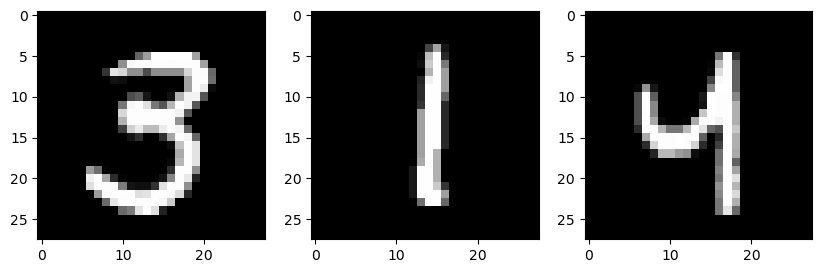

In [13]:
x, y = largest_train[4]

f, axarr = plt.subplots(1,3, figsize=(10,10))
for i in range(3):
    axarr[i].imshow(x[i,0,:].numpy(), cmap='gray', vmin=0, vmax=1)
print("True Label is = ", y)

In [14]:
neurons = 256
classes = 10
simpleNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784*3,neurons), # 784*3 because there are 784 pixels in an image and 3 images in the bag
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes )
)    
simple_results = train_network(simpleNet, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader, epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

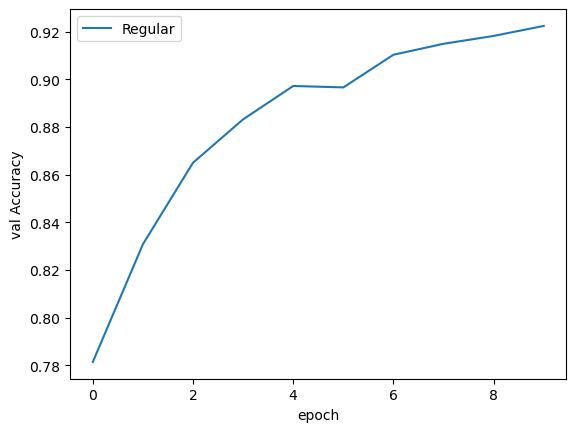

In [15]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')

In [16]:
class Flatten2(nn.Module):
    """
    Takes a vector of shape (A, B, C, D, E, ...)
    and flattens everything but the first two dimensions, 
    giving a result of shape (A, B, C*D*E*...)
    """
    def forward(self, input):
        return input.view(input.size(0), input.size(1), -1)

In [17]:
class Combiner(nn.Module):
    """
    This class is used to combine a feature exraction network F and a importance prediction network W,
    and combine their outputs by adding and summing them together. 
    """

    def __init__(self, featureExtraction, weightSelection):
        """
        featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new 
            representation of shape (B, T, D'). 
        weightSelection: a network that takes in an input of shape (B, T, D') and outputs a 
            tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T 
            values at the end sum to one (torch.sum(_, dim=1) = 1.0)
        """
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection
    
    def forward(self, input):
        """
        input: a tensor of shape (B, T, D)
        return: a new tensor of shape (B, D')
        """
        features = self.featureExtraction(input) #(B, T, D) $\boldsymbol{h}_i = F(\boldsymbol{x}_i)$
        weights = self.weightSelection(features) #(B, T) or (B, T, 1) for $\boldsymbol{\alpha}$
        if len(weights.shape) == 2: #(B, T) shape
            weights.unsqueese(2) #now (B, T, 1) shape
        
        r = features*weights #(B, T, D), computes $\alpha_i \cdot \boldsymbol{h}_i$
        
        return torch.sum(r, dim=1) #sum over the T dimension, giving (B, D) final shape $\bar{\boldsymbol{x}}$

In [18]:
T = 3
D = 784

In [19]:
backboneNetwork = nn.Sequential(
    Flatten2(),# Shape is now (B, T, D)
    nn.Linear(D,neurons), #Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(), #still (B, T, neurons) on the way out
)

In [20]:
attentionMechanism = nn.Sequential(
    #Shape is (B, T, neurons)
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1 ), # (B, T, 1)
    nn.Softmax(dim=1),
)

In [21]:
simpleAttentionNet = nn.Sequential(
        #input is (B, T, C, W, H). backbone & attention will be used by combiner to process
        Combiner(backboneNetwork, attentionMechanism), # result is (B, neurons)
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons,neurons),
        nn.LeakyReLU(),
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons, classes )
    )
simple_attn_results = train_network(simpleAttentionNet, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader, epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

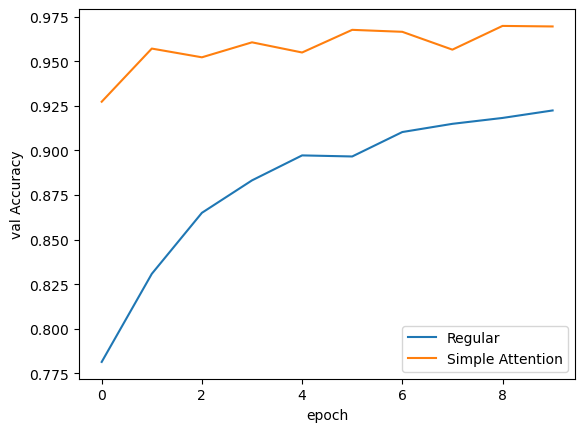

In [22]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_attn_results, label='Simple Attention')

In [23]:
set_seed(1)

True Label is =  7


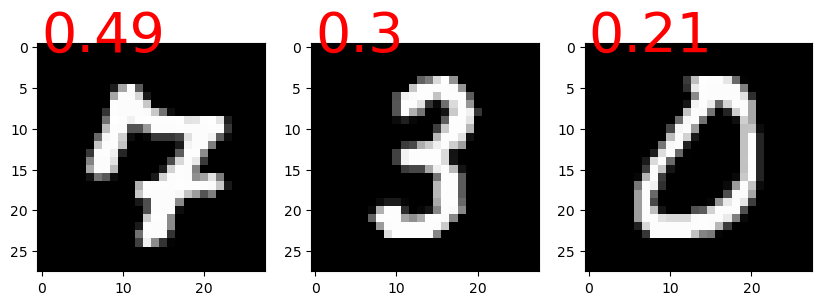

In [29]:
x, y = largest_train[9] # Select a data point (which is a bag)
x = x.to(device) #move it to the compute device

with torch.no_grad():
    weights = attentionMechanism(backboneNetwork(x.unsqueeze(0))) #apply score(F(x))
    weights = weights.cpu().numpy().ravel() #convert to numpy array

f, axarr = plt.subplots(1,3, figsize=(10,10))#make a plot for all 3 digits
for i in range(3):
    axarr[i].imshow(x[i,0,:].cpu().numpy(), cmap='gray', vmin=0, vmax=1) # Plot the digit
    axarr[i].text(0.0, 0.5, str(round(weights[i],2)), dict(size=40, color='red')) #Draw the attention score in the top left
    
print("True Label is = ", y)

In [30]:
class DotScore(nn.Module):

    def __init__(self, H):
        """
        H: the number of dimensions coming into the dot score. 
        """
        super(DotScore, self).__init__()
        self.H = H
    
    def forward(self, states, context):
        """
        states: (B, T, H) shape
        context: (B, H) shape
        output: (B, T, 1), giving a score to each of the T items based on the context 
        
        """
        T = states.size(1)
        #compute $\boldsymbol{h}_t^\top \bar{\boldsymbol{h}}$
        scores = torch.bmm(states,context.unsqueeze(2)) / np.sqrt(self.H) #(B, T, H) -> (B, T, 1)
        return scores

In [31]:
class GeneralScore(nn.Module):

    def __init__(self, H):
        """
        H: the number of dimensions coming into the dot score. 
        """
        super(GeneralScore, self).__init__()
        self.w = nn.Bilinear(H, H, 1) #stores $W$
    
    def forward(self, states, context):
        """
        states: (B, T, H) shape
        context: (B, H) shape
        output: (B, T, 1), giving a score to each of the T items based on the context 
        
        """
        T = states.size(1)
        #Repeating the values T times 
        context = torch.stack([context for _ in range(T)], dim=1) #(B, H) -> (B, T, H)
        #computes $\boldsymbol{h}_{t}^{\top} W \bar{\boldsymbol{h}}$
        scores = self.w(states, context) #(B, T, H) -> (B, T, 1)
        return scores        

In [32]:
class AdditiveAttentionScore(nn.Module):

    def __init__(self, H):
        super(AdditiveAttentionScore, self).__init__()
        self.v = nn.Linear(H, 1) 
        self.w = nn.Linear(2*H, H)#2*H because we are going to concatenate two inputs
    
    def forward(self, states, context):
        """
        states: (B, T, H) shape
        context: (B, H) shape
        output: (B, T, 1), giving a score to each of the T items based on the context 
        
        """
        T = states.size(1)
        #Repeating the values T times 
        context = torch.stack([context for _ in range(T)], dim=1) #(B, H) -> (B, T, H)
        state_context_combined = torch.cat((states, context), dim=2) #(B, T, H) + (B, T, H)  -> (B, T, 2*H)
        scores = self.v(torch.tanh(self.w(state_context_combined))) # (B, T, 2*H) -> (B, T, 1)
        return scores

In [33]:
class ApplyAttention(nn.Module):
    """
    This helper module is used to apply the results of an attention mechanism toa set of inputs. 
    """

    def __init__(self):
        super(ApplyAttention, self).__init__()
        
    def forward(self, states, attention_scores, mask=None):
        """
        states: (B, T, H) shape giving the T different possible inputs
        attention_scores: (B, T, 1) score for each item at each context
        mask: None if all items are present. Else a boolean tensor of shape 
            (B, T), with `True` indicating which items are present / valid. 
            
        returns: a tuple with two tensors. The first tensor is the final context
        from applying the attention to the states (B, H) shape. The second tensor
        is the weights for each state with shape (B, T, 1). 
        """
        
        if mask is not None:
            #set everything not present to a large negative value that will cause vanishing gradients 
            attention_scores[~mask] = -1000.0
        #compute the weight for each score
        weights = F.softmax(attention_scores, dim=1) #(B, T, 1) still, but sum(T) = 1
    
        final_context = (states*weights).sum(dim=1) #(B, T, D) * (B, T, 1) -> (B, D)
        return final_context, weights

In [34]:
def getMaskByFill(x, time_dimension=1, fill=0):
    """
    x: the original input with three or more dimensions, (B, ..., T, ...)
        which may have unsued items in the tensor. B is the batch size, 
        and T is the time dimension. 
    time_dimension: the axis in the tensor `x` that denotes the time dimension
    fill: the constant used to denote that an item in the tensor is not in use,
        and should be masked out (`False` in the mask). 
    
    return: A boolean tensor of shape (B, T), where `True` indicates the value
        at that time is good to use, and `False` that it is not. 
    """
    to_sum_over = list(range(1,len(x.shape))) #skip the first dimension 0 because that is the batch dimension
    
    if time_dimension in to_sum_over:
        to_sum_over.remove(time_dimension)
        
    with torch.no_grad():
        #(x!=fill) determines locations that might be unused, beause they are 
        #missing the fill value we are looking for to indicate lack of use. 
        #We then count the number of non-fill values over everything in that
        #time slot (reducing changes the shape to (B, T)). If any one entry 
        #is non equal to this value, the item represent must be in use - 
        #so return a value of true. 
        mask = torch.sum((x != fill), dim=to_sum_over) > 0
    return mask

In [35]:
with torch.no_grad():
    x = torch.rand((5,3,1,7,7))
    x[0,-1,:] = 0 #Don't use the last item in the first input
    x[3,:] = 0 #Don't use any of the 4'th item!
    x[4,0,0,0] = 0 #Make it _look_ like we aren't using part of the 5th, but we still are!
    #This last line was added to show that this works even on tricky inputs
    
    mask = getMaskByFill(x)
print(mask)

tensor([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True]])


In [36]:
class SmarterAttentionNet(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, score_net=None):
        super(SmarterAttentionNet, self).__init__()
        self.backbone = nn.Sequential(
            Flatten2(),# Shape is now (B, T, D)
            nn.Linear(input_size,hidden_size), #Shape becomes (B, T, H)
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
        )#returns (B, T, H)
        
        #Try changing this and see how the results change!
        self.score_net = AdditiveAttentionScore(hidden_size) if (score_net is None) else score_net

        self.apply_attn = ApplyAttention()
        
        self.prediction_net = nn.Sequential( #(B, H), 
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, out_size ) #(B, H)
        )
        
    
    def forward(self, input):

        mask = getMaskByFill(input)

        h = self.backbone(input) #(B, T, D) -> (B, T, H)

        #h_context = torch.mean(h, dim=1) 
        #computes torch.mean but ignoring the masked out parts
        #first add together all the valid items
        h_context = (mask.unsqueeze(-1)*h).sum(dim=1)#(B, T, H) -> (B, H)
        #then divide by the number of valid items, pluss a small value incase a bag was all empty
        h_context = h_context/(mask.sum(dim=1).unsqueeze(-1)+1e-10)

        scores = self.score_net(h, h_context) # (B, T, H) , (B, H) -> (B, T, 1)

        final_context, _ = self.apply_attn(h, scores, mask=mask)

        return self.prediction_net(final_context)
        

In [37]:
attn_dot = SmarterAttentionNet(D, neurons, classes, score_net=DotScore(neurons))
attn_gen = SmarterAttentionNet(D, neurons, classes, score_net=GeneralScore(neurons))
attn_add = SmarterAttentionNet(D, neurons, classes, score_net=AdditiveAttentionScore(neurons))

attn_results_dot = train_network(attn_dot, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader,epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
attn_results_gen = train_network(attn_gen, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader,epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
attn_results_add = train_network(attn_add, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader,epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

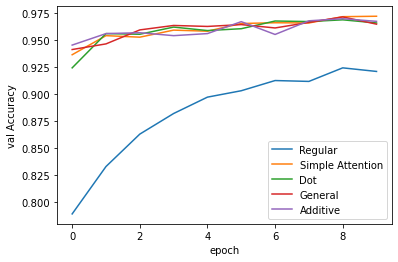

In [29]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_attn_results, label='Simple Attention')
sns.lineplot(x='epoch', y='val Accuracy', data=attn_results_dot, label='Dot')
sns.lineplot(x='epoch', y='val Accuracy', data=attn_results_gen, label='General')
sns.lineplot(x='epoch', y='val Accuracy', data=attn_results_add, label='Additive')

In [30]:
class LargestDigitVariable(Dataset):
    """
    Creates a modified version of a dataset where some variable number of samples are 
    taken, and the true label is the largest label sampled. When used with MNIST the
    labels correspond to their values (e.g., digit "6" has label 6). Each datum will 
    be padded with 0 values if the maximum number of items was not sampled. 
    """

    def __init__(self, dataset, maxToSample=6):
        """
        dataset: the dataset to sample from
        toSample: the number of items from the dataset to sample
        """
        self.dataset = dataset
        self.maxToSample = maxToSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        #NEW: how many items should we select?
        how_many = np.random.randint(1,self.maxToSample, size=1)[0]
        #Randomly select n=self.toSample items from the dataset
        selected = np.random.randint(0,len(self.dataset), size=how_many)
        
        #Stack the n items of shape (B, *) shape into (B, n, *)
        #NEW: pad with zero values up to the max size
        x_new = torch.stack([self.dataset[i][0] for i in selected] + 
                            [torch.zeros((1,28,28)) for i in range(self.maxToSample-how_many)])
        #Label is the maximum label
        y_new = max([self.dataset[i][1] for i in selected])
        #Return (data, label) pair
        return x_new, y_new

In [31]:
largestV_train = LargestDigitVariable(mnist_train)
largestV_test = LargestDigitVariable(mnist_test)

trainV_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
testV_loader = DataLoader(largest_test, batch_size=B)

In [32]:
attn_dot = attn_dot.eval()

preds = []
truths = []
with torch.no_grad():
    for inputs, labels in testV_loader:
        pred = attn_dot(inputs.to(device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        
        preds.extend(pred.ravel())
        truths.extend(labels.numpy().ravel())
print("Variable Length Accuracy: ", accuracy_score(preds, truths))

Variable Length Accuracy:  0.967
